In [1]:
from CRM.crm_basico_pipeline import *
from CRM.classical_crm import *
import tellurium as te


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.3.0 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/Users/edwin/anaconda3/lib/python3.11/site-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "/Users/edwin/anaconda3/lib/python3.11/site-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/Users/edwin/anaconda3/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 736, in start
    self.io_loop.start()
  File "/Users/edwin

AttributeError: _ARRAY_API not found


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.3.0 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/Users/edwin/anaconda3/lib/python3.11/site-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "/Users/edwin/anaconda3/lib/python3.11/site-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/Users/edwin/anaconda3/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 736, in start
    self.io_loop.start()
  File "/Users/edwin

AttributeError: _ARRAY_API not found


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.3.0 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/Users/edwin/anaconda3/lib/python3.11/site-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "/Users/edwin/anaconda3/lib/python3.11/site-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/Users/edwin/anaconda3/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 736, in start
    self.io_loop.start()
  File "/Users/edwin

AttributeError: _ARRAY_API not found


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.3.0 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/Users/edwin/anaconda3/lib/python3.11/site-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "/Users/edwin/anaconda3/lib/python3.11/site-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/Users/edwin/anaconda3/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 736, in start
    self.io_loop.start()
  File "/Users/edwin

AttributeError: _ARRAY_API not found

OSQP and HIGHS are available but could not load the hybrid interface.
Traceback (most recent call last):
  File "/Users/edwin/anaconda3/lib/python3.11/site-packages/optlang/__init__.py", line 61, in <module>
    from optlang import hybrid_interface
  File "/Users/edwin/anaconda3/lib/python3.11/site-packages/optlang/hybrid_interface.py", line 26, in <module>
    import optlang.matrix_interface as mi
  File "/Users/edwin/anaconda3/lib/python3.11/site-packages/optlang/matrix_interface.py", line 40, in <module>
    from numpy import Infinity, array, concatenate, zeros
ImportError: cannot import name 'Infinity' from 'numpy' (/Users/edwin/anaconda3/lib/python3.11/site-packages/numpy/__init__.py)


In [2]:
# Load gut normal models
gut_normal = {
    'B. caccae': '/Users/edwin/Downloads/reconstructions/GSMM/Bacteroides_caccae_ATCC_43185.xml',
    'E. rectale': '/Users/edwin/Downloads/reconstructions/GSMM/Eubacterium_rectale_ATCC_33656.xml'}

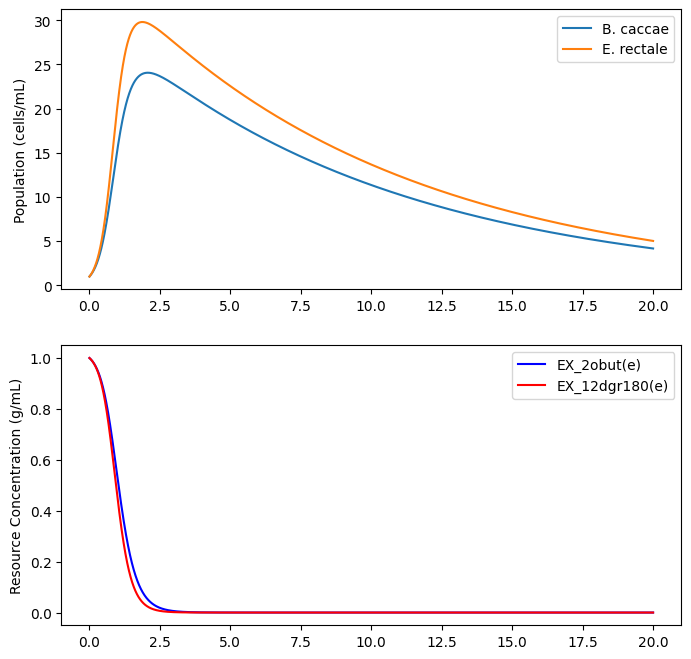

In [3]:
# take the model files, extract
a = species_data(gut_normal)
crm_basico = new_model(name='basico_crm')
new_basico = basico_model("basico_crm", a)

# run basico model and save results
t = np.linspace(0, 20, 5001)
result_default = run_time_course(model=new_basico, duration=500, values=t)

# display/plot results
plt.figure(figsize=(8, 8))

# Population Growth
plt.subplot(2, 1, 1)
plt.plot(result_default.index, result_default['B._caccae'], label='B. caccae')
plt.plot(result_default.index, result_default['E._rectale'], label='E. rectale')
plt.ylabel('Population (cells/mL)')
plt.legend()

# Resource Dynamics
plt.subplot(2, 1, 2)
plt.plot(result_default.index, result_default['EX_2obut(e)'], label='EX_2obut(e)', color='blue')
plt.plot(result_default.index, result_default['EX_12dgr180(e)'], label='EX_12dgr180(e)', color='red')
plt.ylabel('Resource Concentration (g/mL)')
plt.legend()
plt.show()

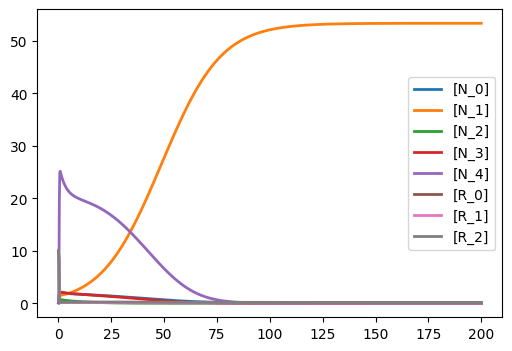

In [4]:
np.random.seed(42)

num_species = 5
num_resources = 3

params = {
    "tau": np.random.uniform(0.5, 1.5, num_species),
    "m":   np.random.uniform(0.1, 0.3, num_species),
    "w":   np.random.uniform(0.5, 1.0, num_resources),
    "c":   np.random.uniform(0.1, 1.0, (num_species, num_resources)),
    "K":   np.full(num_resources, 10.0),
    "r":   np.random.uniform(0.1, 0.5, num_resources)
}

initial_N = np.array([0.2, 0.1, 0.05, 0.1, 0.1])
initial_R = np.array([10.0, 10.0, 10.0])

# Generate Antimony string
ant_str = generate_antimony_crm_multi(num_species, num_resources, params, initial_N, initial_R, resource_mode='external')

# Load into Tellurium
import tellurium as te
r = te.loada(ant_str)
sbml_str = r.getSBML()

r.simulate(0, 200, 1000)
r.plot()

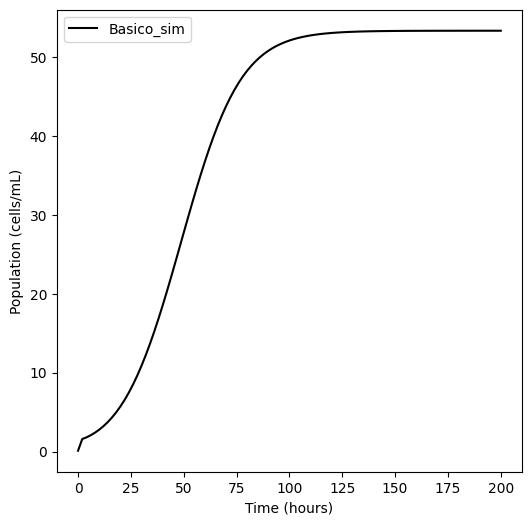

In [5]:
model_adaptation = load_model(sbml_str)
result_default = run_time_course(model=model_adaptation, duration=200)
# Plot experimental data and MCMC simulation
plt.figure(figsize=(6, 6))
# Plot the mean density as a line
plt.plot(result_default.index, result_default['N_1'], label="Basico_sim", color="black")
plt.ylabel('Population (cells/mL)')
plt.xlabel("Time (hours)")
plt.legend()
plt.show()

In [6]:

params, resources, species = generate_crm_parameters_from_sbml(gut_normal)

# Simulate
result = simulate_crm(params, scenario_name=None,
                      num_species=len(species),
                      num_resources=len(resources),
                      timesteps=10000,
                      dt=0.01,
                      plot=False)

Simulating the classical MacArthur CRM with logistic resource growth...


In [7]:
num_species = len(species)
num_resources = len(resources)
initial_N = [0.1] * num_species
initial_R = [10.0] * num_resources

ant_str = generate_antimony_crm_multi(
    num_species=num_species,
    num_resources=num_resources,
    params=params,
    initial_N=initial_N,
    initial_R=initial_R,
    resource_mode='logistic'  # or 'external' or 'tilman'
)

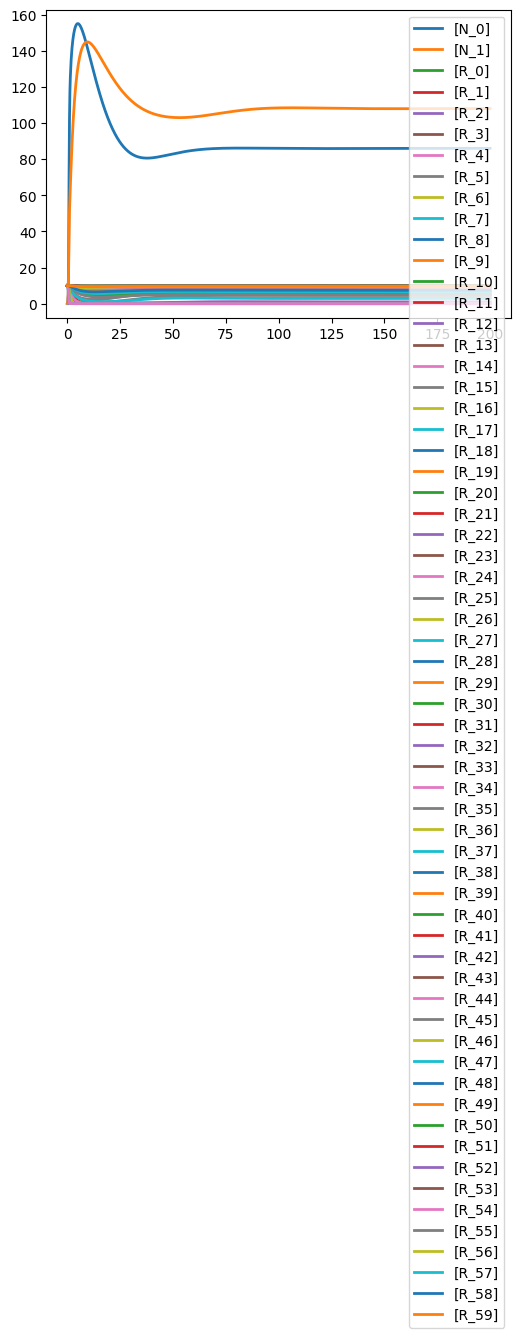

In [8]:

r = te.loada(ant_str)
r.simulate(0, 200, 1000)
r.plot()

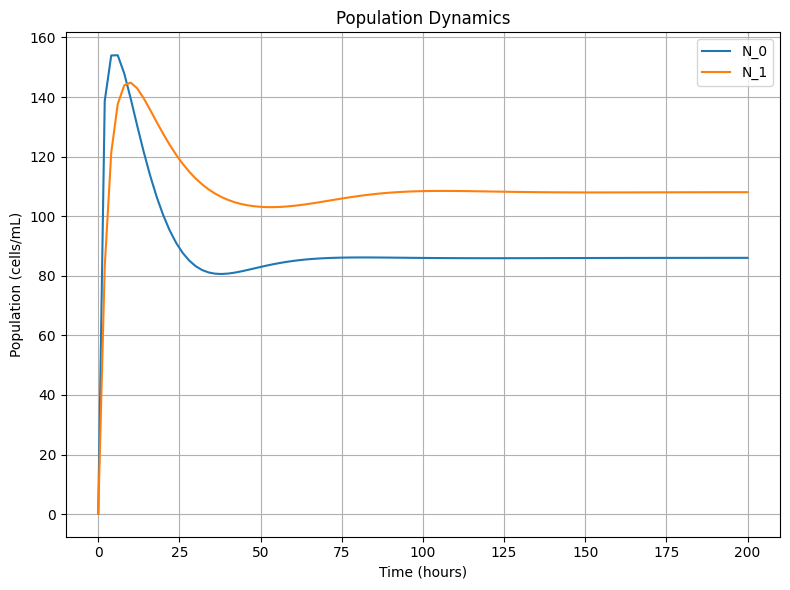

In [11]:
# Generate sbml and run it in basico
result_default = run_basico_simulation_from_antimony(ant_str, duration=200)

# Plot all populations
plot_all_species_trajectories(result_default, species_prefix='N_')

/Users/edwin/PycharmProjects/CRM/CRM/crm_basico_pipeline.py:297: UserWarning:

Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.



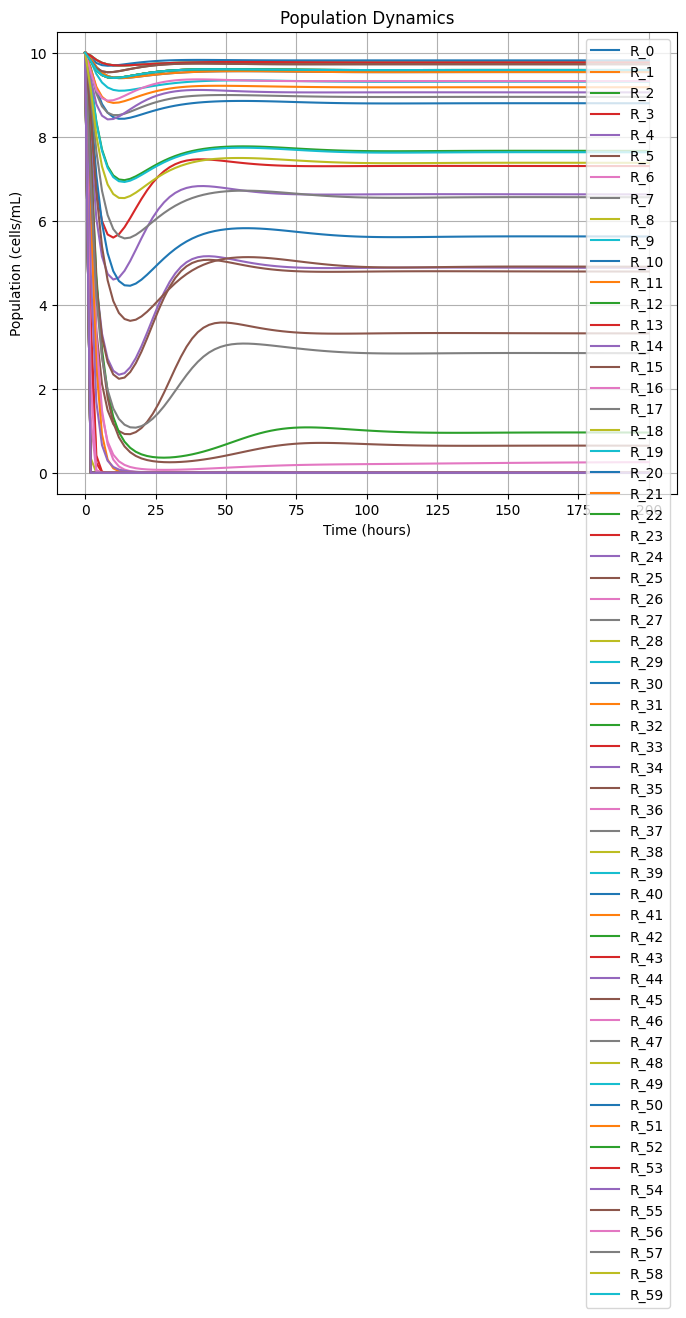

In [12]:
plot_all_species_trajectories(result_default, species_prefix='R_')